In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import itertools

from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, precision_recall_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('churn_data.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional 
    transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, x, y=None):
        self.columns = [col for col in pd.get_dummies(x, prefix=self.key).columns]
        return self

    def transform(self, x):
        x = pd.get_dummies(x, prefix=self.key)
        test_columns = [col for col in x.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                x[col_] = 0
        return x[self.columns]

In [5]:
def best_metrics(y_test, y_pred):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fscore = (2 * precision * recall) / (precision + recall)
    fscore = np.nan_to_num(fscore)
    ix = np.argmax(fscore)
    best_thresholds, best_fscore = np.around(thresholds[ix], 3), np.around(fscore[ix], 3)
    best_precision, best_recall = np.around(precision[ix], 3), np.around(recall[ix], 3)
    
    roc_auc = round(roc_auc_score(y_test, y_pred), 3)
    
    cnf_matrix = confusion_matrix(y_test, y_pred > thresholds[ix])
    tn = cnf_matrix[0][0]
    fn = cnf_matrix[1][0]
    tp = cnf_matrix[1][1]
    fp = cnf_matrix[0][1]
    accuracy = round((tp + tn) / (tp + tn + fp + fn), 3)
    
    logloss = round(log_loss(y_test, y_pred), 3)
    
    return best_thresholds, best_fscore, best_precision, best_recall, roc_auc, accuracy, logloss

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
df = pd.read_csv('churn_data.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
x_train, x_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42)

In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [10]:
final_transformers = []

for cat_col in categorical_columns:
    cat_transformer = Pipeline([('selector', FeatureSelector(column=cat_col)), 
                                ('ohe', OHEEncoder(key=cat_col))])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([('selector', NumberSelector(key=cont_col)), 
                                 ('scaler', StandardScaler())])
    final_transformers.append((cont_col, cont_transformer))

In [11]:
feats = FeatureUnion(final_transformers)

In [12]:
classifiers = [LogisticRegression(random_state=42),
               CatBoostClassifier(silent=True, random_state=42)]

In [13]:
metrics = pd.DataFrame(columns=['model', 'threshold', 'f1-score', 'precision', 'recall', 
                                'roc auc', 'accuracy', 'logistic loss'])

In [14]:
for clf in classifiers:
    pipeline = Pipeline([('features', feats), ('classifier', clf)])
    pipeline.fit(x_train, y_train)
    
    y_pred = pipeline.predict_proba(x_test)[:, 1]
    data = best_metrics(y_test, y_pred)
    
    metrics.loc[len(metrics.index)] = [clf.__class__.__name__, *data]

In [15]:
metrics

,model,threshold,f1-score,precision,recall,roc auc,accuracy,logistic loss
0,LogisticRegression,0.274,0.503,0.443,0.581,0.773,0.771,0.42
1,CatBoostClassifier,0.273,0.643,0.593,0.702,0.872,0.844,0.32


По всем метрикам лучше на предоставленных данных работает модель категориального бустинга. Конечно, мы отбирали лучшую модель по метрике f1-score, это уже вошло в привычку и стало очевидным)

In [16]:
best_model = pipeline
best_y_pred = y_pred
best_threshold = data[0]

Confusion matrix, without normalization
[[1764  239]
 [ 149  348]]


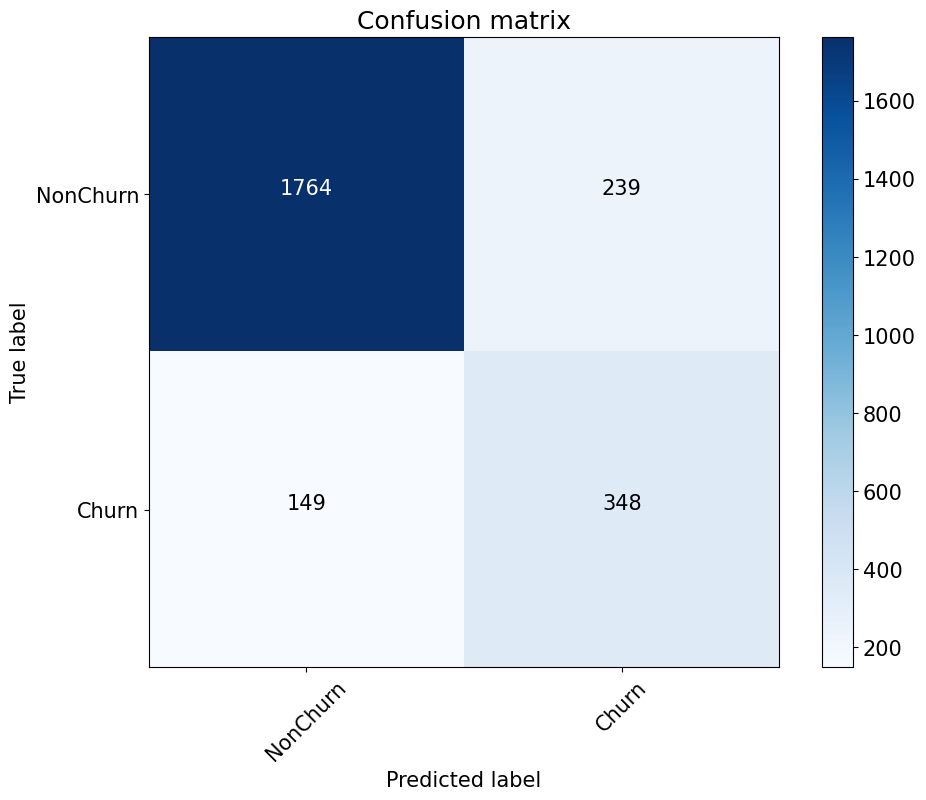

In [17]:
cnf_matrix = confusion_matrix(y_test, best_y_pred > best_threshold)

font = {'size': 15}

plt.rc('font', **font)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.show()

In [18]:
tp = cnf_matrix[1][1]
fp = cnf_matrix[0][1]

retain_sum = (fp + tp) * 1
income = tp * 2
print(f'Сумма, потраченная на удержание пользователей: ${retain_sum}, доход с оставшихся '
      f'пользователей: ${income}, общая прибыль: ${income - retain_sum}.')

Сумма, потраченная на удержание пользователей: $587, доход с оставшихся пользователей: $696, общая прибыль: $109.


In [19]:
params = {'classifier__iterations': [800, 1000, 1200], 
          'classifier__l2_leaf_reg': [1, 3, 5], 
          'classifier__learning_rate': [.01, .02, .03], 
          'classifier__max_depth': [6, 8, 10], 
          'classifier__min_data_in_leaf': [1, 5, 10], 
          'classifier__subsample': [.6, .8, .9]}

In [20]:
# %%time
# grid = GridSearchCV(best_model, param_grid=params, scoring='f1', refit=False)
# search = grid.fit(x_train, y_train)
# search.best_params_

In [21]:
# CPU times: user 45min 20s, sys: 3min 24s, total: 48min 45s
# Wall time: 11min 16s
# {'classifier__iterations': 1200,
#  'classifier__l2_leaf_reg': 5,
#  'classifier__learning_rate': 0.02,
#  'classifier__max_depth': 6,
#  'classifier__min_data_in_leaf': 1,
#  'classifier__subsample': .9}

In [22]:
best_pipe = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(iterations=1200, l2_leaf_reg=5, learning_rate=.02, 
                                      max_depth=6, min_data_in_leaf=1, random_state=42, 
                                      silent=True, subsample=.9))])

best_pipe.fit(x_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fddb936ac80>)])

In [23]:
best_preds = best_pipe.predict_proba(x_test)[:, 1]

In [24]:
b_precision, b_recall, b_thresholds = precision_recall_curve(y_test, best_preds)

b_fscore = (2 * b_precision * b_recall) / (b_precision + b_recall)
b_ix = np.argmax(b_fscore)
print(f'Best Threshold={b_thresholds[b_ix]:.3}, F-Score={b_fscore[b_ix]:.3f}, ' 
      f'Precision={b_precision[b_ix]:.3f}, Recall={b_recall[b_ix]:.3f}')

Best Threshold=0.286, F-Score=0.652, Precision=0.613, Recall=0.696


Confusion matrix, without normalization
[[1785  218]
 [ 152  345]]


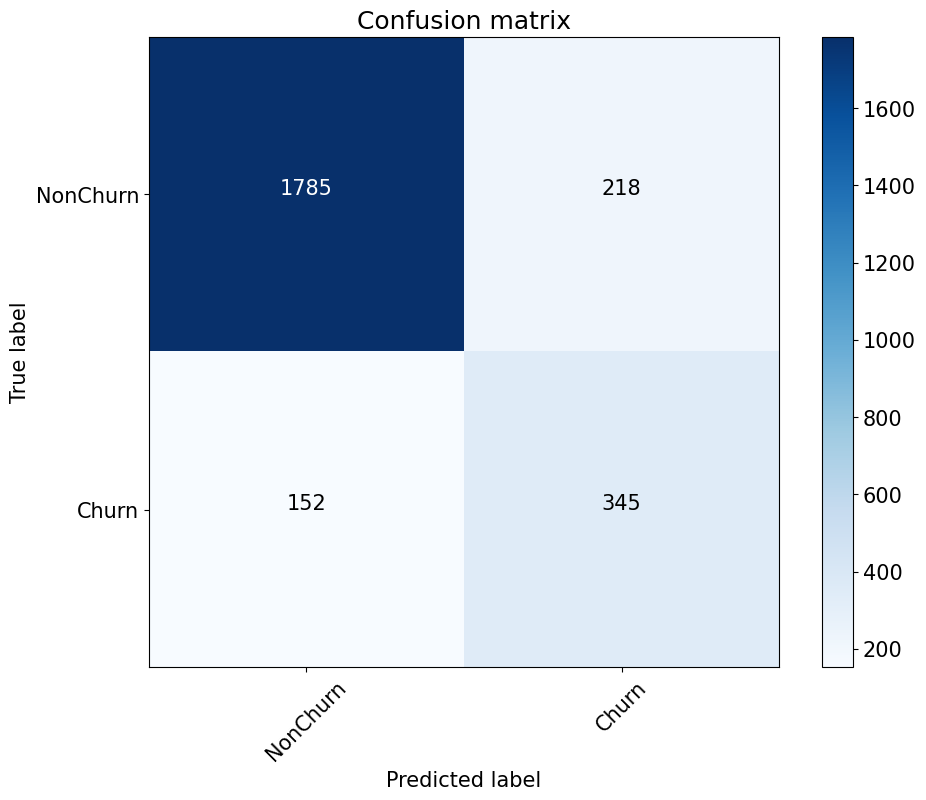

In [25]:
cnf_matrix_b = confusion_matrix(y_test, best_preds > b_thresholds[b_ix])

font = {'size': 15}

plt.rc('font', **font)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_b, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.show()

In [26]:
tp_b = cnf_matrix_b[1][1]
fp_b = cnf_matrix_b[0][1]

retain_sum_b = (fp_b + tp_b) * 1
income_b = tp_b * 2
print(f'Сумма, потраченная на удержание пользователей: ${retain_sum_b}, доход с оставшихся '
      f'пользователей: ${income_b}, общая прибыль: ${income_b - retain_sum_b}.')

Сумма, потраченная на удержание пользователей: $563, доход с оставшихся пользователей: $690, общая прибыль: $127.


С подбором гиперпараметров мы заработали на 18 долларов больше, но параметры подбирались очень долго, почти час, тут как никогда  месту поговорка "время - деньги".